<a href="https://colab.research.google.com/github/codeSamuraii/ml-experiments/blob/main/CompressionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JPEG Compression detection with Keras
The objective of this notebook is to train a machine learning model to recognise images that have been compressed using a lossy algorithm (such as JPEG) from original high-quality ones.

## Fetching and preparing the dataset files
We'll use a landscape images dataset from Kaggle.

_You'll need a Kaggle account to download the dataset._

In [1]:
import os
import getpass

kaggle_ids = getpass.getpass('Content of your ~/.kaggle/kaggle.json: ')
os.environ['KAGGLE_JSON'] = kaggle_ids

!mkdir ~/.kaggle; echo $KAGGLE_JSON > ~/.kaggle/kaggle.json; chmod 600 ~/.kaggle/kaggle.json

Content of your ~/.kaggle/kaggle.json: ··········


Download the dataset:

In [2]:
!mkdir /content/dataset; kaggle datasets download -d arnaud58/landscape-pictures -p /content/dataset --unzip

100% 620M/620M [00:32<00:00, 23.2MB/s]
100% 620M/620M [00:32<00:00, 20.2MB/s]


We'll JPEG-compress the images using Pillow, and put them in separate folders under `training`, one for `compressed` images, one for `quality` images:

In [ ]:
!mkdir /content/training; mkdir /content/training/compressed; mkdir /content/training/quality

import os
import pathlib
import tensorflow as tf
from PIL import Image
from itertools import chain


quality_factor = 5

def process_images_for_training(src_dataset, dest_directory, ext_glob=None):
    # Images have different extensions
    folder = pathlib.Path(src_dataset).resolve()
    extensions = ext_glob or {'*.jpg', '*.jpeg'}
    images = list(chain.from_iterable(folder.glob(ext) for ext in extensions))
    nb_img, nb_errors = len(images), 0
    print(f'Found {nb_img} images.')

    for i, image_file in enumerate(images):
        try:
            im = Image.open(image_file, formats=['JPEG'])
            im.save(f'{dest_directory}/quality/{i}.jpg', optimize=True, quality='keep')
        except (OSError, ValueError):
            nb_errors += 1
            continue

        im.save(f'{dest_directory}/compressed/{i}.jpg', optimize=False, quality=quality_factor)

        if i % 1000 == 0:
            progress = int(i / nb_img * 100)
            print(f'{progress}% ({i}/{nb_img} E={nb_errors})')

    print('Done.')

process_images_for_training('/content/dataset', '/content/training')

## Splitting the dataset
Now that we have created our compressed images, let's use Keras to split the dataset between training and validation. Keras will understand that each subdirectory of `training` is a class we're trying to predict.

In [1]:
import tensorflow as tf


batch_size = 12
img_height = 500
img_width = 500


def dataset_from_directory(training_dir):
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        training_dir,
        validation_split=0.2,
        subset='training',
        seed=321,
        image_size=(img_height, img_width),
        crop_to_aspect_ratio=True,
        # label_mode='binary',
        batch_size=batch_size
    )
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        training_dir,
        validation_split=0.2,
        subset='validation',
        seed=321,
        image_size=(img_height, img_width),
        crop_to_aspect_ratio=True,
        # label_mode='binary',
        batch_size=batch_size
    )

    return train_dataset, validation_dataset

train_dataset, validation_dataset = dataset_from_directory('/content/training')
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f'{num_classes} classes: {class_names}')

Found 8638 files belonging to 2 classes.
Using 6911 files for training.
Found 8638 files belonging to 2 classes.
Using 1727 files for validation.
2 classes: ['compressed', 'quality']


Note that the dataset has been configured to perform a _categorical_ classification.

It is suited for classifications with two or more classes. The output will be the computed probability for an image to belong to each class: `[0.97, 0.03]` for example.

> Considering we are only trying to predict if an image is compressed or not, we could have used a _binary_ classification, which would only output "yes" (`1`) or "no" (`0`). For that we would need to uncomment `label_mode='binary'` and modify the model's output layer.

We check that pictures have been assigned to the correct label:

Pixel values in [0.0:255.0]


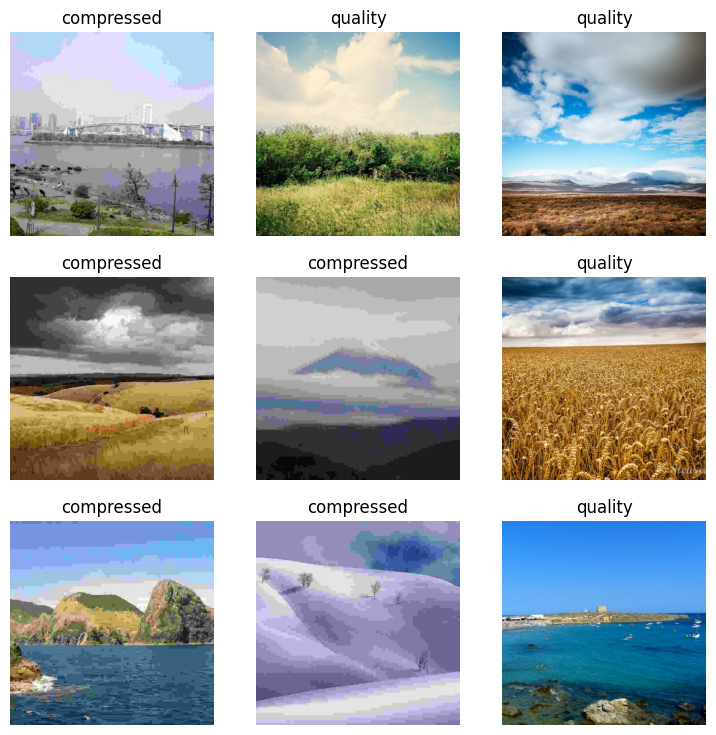

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def show_dataset(dataset):
    plt.figure(figsize=(9, 9))
    for images, labels in dataset.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

    image_batch, _ = next(iter(dataset))
    first_image = image_batch[0]
    print(f'Pixel values in [{np.min(first_image)}:{np.max(first_image)}]')

show_dataset(train_dataset)

We can see that compressed images have artifacts, especially in gradient areas like the sky. Our model should be able to pick up these details.

## Create the model and train
We create a basic CNN network made of convolutions and pooling layers increasing in filter size.

To prevent overfitting, the images go through preprocessing layers where data augmentation operations are performed such as flip, zoom and rotation. Two dropouts layers further help stabilising predictions.

Data is rescaled to the `[0: 100]` range during that process as it is common when using RGB data.

We also put in place checkpoint and early stopping callbacks that will stop the training prematurely if performance drops and restore the best weights.

> For a *binary* classification, we would need an output layer of dimension `1` with sigmoid activation and a *binary crossentropy* loss function.

In [3]:
import tempfile
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


preprocess = keras.Sequential([
    # Augmentation
    layers.RandomFlip(input_shape=(img_height, img_width, 3)),
    layers.RandomZoom((0.0, 0.2)),
    layers.RandomRotation(0.1, fill_mode='constant'),

    # Rescaling
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
])

model = Sequential([
    preprocess,

    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),

    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='Adamax',
              loss='sparse_categorical_crossentropy',  # loss='binary_crossentropy',
              metrics=['accuracy'])

_, checkpoint_file = tempfile.mkstemp(prefix='checkpoint_', suffix='.h5', dir='/tmp')
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_file, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(start_from_epoch=10, patience=6, restore_best_weights=True)

history = model.fit(train_dataset, epochs=30, validation_data=validation_dataset, callbacks=[checkpoint, early_stop])

loss, accuracy = model.evaluate(validation_dataset)
print("Loss: ", loss)
print("Accuracy: ", accuracy)



Epoch 1/30
576/576 [==============================] - ETA: 0s - loss: 0.7705 - accuracy: 0.5103

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


576/576 [==============================] - 150s 250ms/step - loss: 0.7705 - accuracy: 0.5103 - val_loss: 0.6761 - val_accuracy: 0.5970
Epoch 2/30
576/576 [==============================] - 137s 238ms/step - loss: 0.6571 - accuracy: 0.5784 - val_loss: 0.6199 - val_accuracy: 0.6051
Epoch 3/30
576/576 [==============================] - 142s 247ms/step - loss: 0.5751 - accuracy: 0.6550 - val_loss: 0.5233 - val_accuracy: 0.7522
Epoch 4/30
576/576 [==============================] - 139s 242ms/step - loss: 0.4901 - accuracy: 0.7394 - val_loss: 0.4513 - val_accuracy: 0.8002
Epoch 5/30
576/576 [==============================] - 137s 238ms/step - loss: 0.3524 - accuracy: 0.8411 - val_loss: 0.3210 - val_accuracy: 0.8836
Epoch 6/30
576/576 [==============================] - 139s 240ms/step - loss: 0.2446 - accuracy: 0.8955 - val_loss: 0.1748 - val_accuracy: 0.9323
Epoch 7/30
576/576 [==============================] - 129s 224ms/step - loss: 0.1567 - accuracy: 0.9349 - val_loss: 0.1796 - val_accura

We can see the model wasn't improving after epoch 26, weights have therefore been restored to that training step.

## Review performance

Let's plot the training statistics :

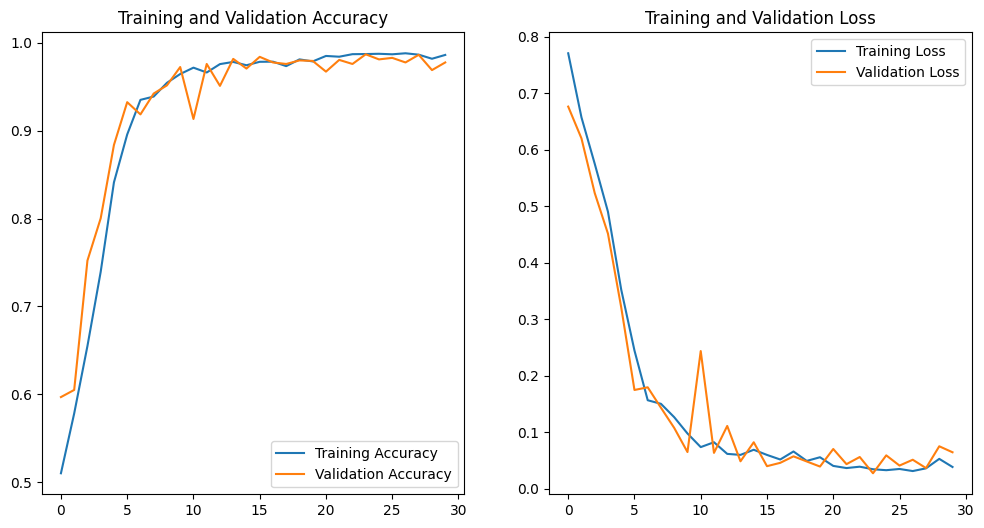

In [4]:
def plot_performance(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    nb_epochs = len(history.history['val_loss'])
    epochs_range = range(nb_epochs)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

plot_performance(history)

We can see that there was no overfitting and validation loss nicely follows training.

## Make some predictions
Let's try some random predictions :

In [45]:
import random
import numpy as np
from random import choice


def gen_random_class_and_images(n):
    compressed_files = list(pathlib.Path(f'/content/training/compressed').glob('*.jpg'))
    quality_files = list(pathlib.Path(f'/content/training/quality').glob('*.jpg'))
    classes = [
        ('compressed', lambda: random.choice(compressed_files)),
        ('quality', lambda: random.choice(quality_files))
    ]

    for _ in range(n):
        rand_class, rand_img = random.choice(classes)
        yield rand_class, rand_img()

# 100 random predictions
for rand_class, rand_img in gen_random_class_and_images(100):
    img = tf.keras.utils.load_img(rand_img, target_size=(img_height, img_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array, verbose=False)
    score = tf.nn.softmax(predictions[0])

    pred_class, pred_confidence = class_names[np.argmax(score)], 100 * np.max(score)
    if pred_class != rand_class:
        print(f'FAIL - input: {rand_class} > pred: {pred_class} ({pred_confidence:.2f}) - {rand_img}')


FAIL - input: compressed > pred: quality (58.22) - /content/training/compressed/916.jpg
FAIL - input: quality > pred: compressed (63.58) - /content/training/quality/692.jpg


We can see that our model performs decently. When it fails to predict the right answer, the confidence score is low (~60%). In a real application, we could filter results with a minimum score.

## Save the model
Let's save our model, we can use it for predictions straight away or for reinforcement learning.

In [6]:
print("Saving model...")
file_name = f'trained_q{quality_factor}_{int(accuracy * 1000)}'
_, model_file = tempfile.mkstemp(prefix=file_name + '_', suffix='.keras', dir='/content')
tf.keras.models.save_model(model, model_file)
print("Saved to: ", model_file)

if input('Save compressed to Drive ? [y/N] ') in {'y', 'Y'}:
    os.environ['TMP_MODEL_PATH'] = model_file
    os.environ['XZ_MODEL_NAME'] = file_name + '.xz'
    !xz -9 -T 0 -v --keep --stdout $TMP_MODEL_PATH > /content/drive/MyDrive/trained_models/$XZ_MODEL_NAME

Saving model...
Saved to:  /content/trained_q5_986_348e0gyk.keras
Save compressed to Drive ? [y/N] n


# Improving generalization with transfer learning
Our current model is able to differentiate compressed _landscape_ images from original ones. However, it wouldn't perform well with a different kind of picture.

Using transfer learning and a different set of pictures, we'll improve our model ability to generalize.

## Download and prepare the new dataset
Just like before, we'll download an image dataset and process images into two categories.

In [47]:
!mkdir /content/dataset2; kaggle datasets download -d farhanhaikhan/general-purpose-image-dataset -p /content/dataset2 --unzip; mv dataset2/dataset/* dataset2/

100% 1.45G/1.45G [01:22<00:00, 8.92MB/s]
100% 1.45G/1.45G [01:22<00:00, 18.9MB/s]


In [11]:
!mkdir /content/training2; mkdir /content/training2/compressed; mkdir /content/training2/quality

process_images_for_training('/content/dataset2', '/content/training2', ext_glob={'*/*.jpg', '*/*.jpeg'})

Found 5894 images.
0% (0/5894 E=0)
16% (1000/5894 E=21)
33% (2000/5894 E=41)
50% (3000/5894 E=77)
67% (4000/5894 E=90)
84% (5000/5894 E=104)
Done.


Found 11552 files belonging to 2 classes.
Using 9242 files for training.
Found 11552 files belonging to 2 classes.
Using 2310 files for validation.
2 classes: ['compressed', 'quality']
Pixel values in [0.0:255.0]


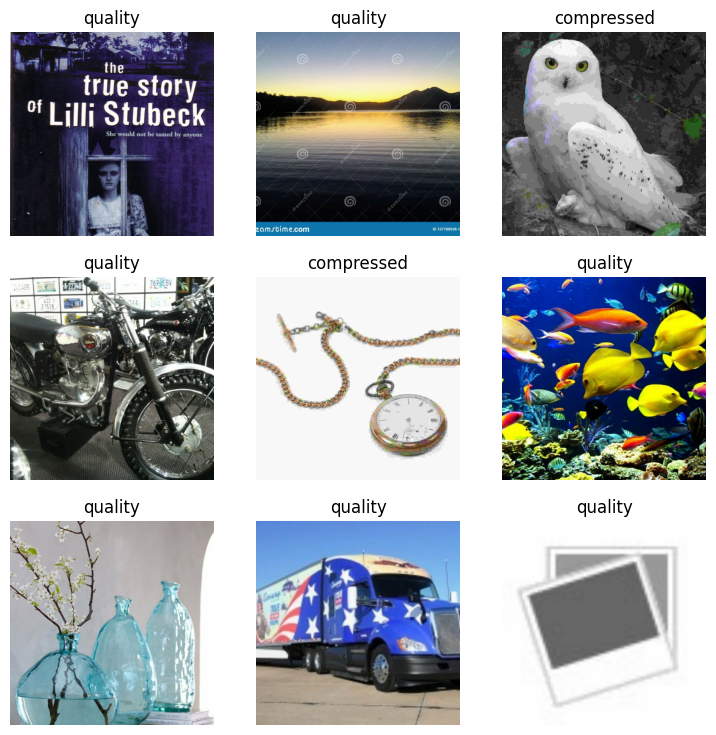

In [12]:
train_dataset_2, validation_dataset_2 = dataset_from_directory('/content/training2')

class_names = train_dataset_2.class_names
num_classes = len(class_names)
print(f'{num_classes} classes: {class_names}')

show_dataset(train_dataset_2)

## Creating a new model from the previous one
We'll first load the model we want to use as a base for our transfer learning, connect new dense layers (discarding the base model's final prediction layer) and freeze the convolution layers with `layer.trainable=False`.

In [13]:
!rm /tmp/*.h5 2> /dev/null
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model, Model


base_model = load_model(model_file)

# We discard the last dense layers and connect to the biggest one
base = base_model.layers[len(base_model.layers) - 3].output

# We add new dense layers
new_model = layers.Dense(512, activation='relu')(base)
new_model = layers.Dropout(0.2)(new_model)
new_model = layers.Dense(256, activation='relu')(new_model)
new_model = layers.Dense(128, activation='relu')(new_model)
new_model = layers.Dense(num_classes, activation='softmax')(new_model)
new_model = Model(inputs=base_model.input, outputs=new_model)

nb_layers_new = len(new_model.layers)
nb_layers_to_train = nb_layers_new - 5

# We freeze every layer except the four we just added
for i in range(1, nb_layers_to_train):
    new_model.layers[i].trainable = False
for i in range(nb_layers_to_train, nb_layers_new):
    new_model.layers[i].trainable = True


new_model.summary(expand_nested=True, show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 sequential_input (InputLay  [(None, 500, 500, 3)]     0         Y          
 er)                                                                        
                                                                            
 sequential (Sequential)     (None, 500, 500, 3)       0         N          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| random_flip (RandomFlip)   (None, 500, 500, 3)       0         N         |
|                                                                          |
| random_zoom (RandomZoom)   (None, 500, 500, 3)       0         N         |
|                                                                          |
| random_rotation (RandomRo  (None, 500, 500, 3)       0         N         |
| tation)                                                    

Epoch 1/50
771/771 [==============================] - ETA: 0s - loss: 0.1752 - accuracy: 0.9316

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


771/771 [==============================] - 52s 65ms/step - loss: 0.1752 - accuracy: 0.9316 - val_loss: 0.1439 - val_accuracy: 0.9403
Epoch 2/50
771/771 [==============================] - 50s 65ms/step - loss: 0.1624 - accuracy: 0.9371 - val_loss: 0.1432 - val_accuracy: 0.9403
Epoch 3/50
771/771 [==============================] - 50s 64ms/step - loss: 0.1592 - accuracy: 0.9377 - val_loss: 0.1429 - val_accuracy: 0.9403
Epoch 4/50
771/771 [==============================] - 49s 64ms/step - loss: 0.1552 - accuracy: 0.9386 - val_loss: 0.1426 - val_accuracy: 0.9377
Epoch 5/50
771/771 [==============================] - 50s 64ms/step - loss: 0.1539 - accuracy: 0.9392 - val_loss: 0.1395 - val_accuracy: 0.9403
Epoch 6/50
771/771 [==============================] - 48s 61ms/step - loss: 0.1518 - accuracy: 0.9407 - val_loss: 0.1408 - val_accuracy: 0.9411
Epoch 7/50
771/771 [==============================] - 50s 64ms/step - loss: 0.1505 - accuracy: 0.9411 - val_loss: 0.1374 - val_accuracy: 0.9424
Epo

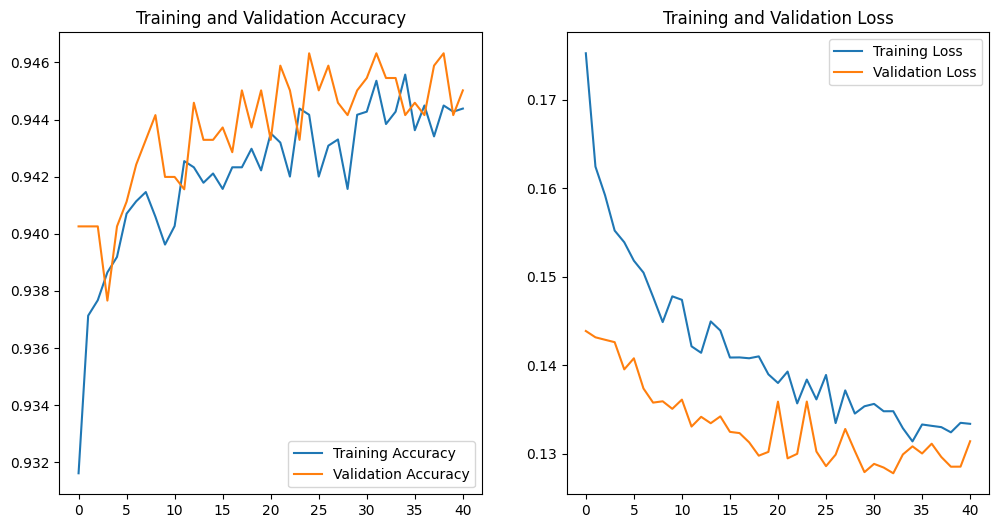

In [14]:
import tempfile
import tensorflow as tf

new_model.compile(optimizer='Adamax',
                  loss='sparse_categorical_crossentropy',  # loss='binary_crossentropy',
                  metrics=['accuracy'])

_, checkpoint_file = tempfile.mkstemp(prefix='checkpoint_', suffix='.h5', dir='/tmp')
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_file, save_best_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=8, start_from_epoch=20, restore_best_weights=True)

history_2 = new_model.fit(train_dataset_2, epochs=50, validation_data=validation_dataset_2, callbacks=[checkpoint, early_stop])

loss, accuracy = new_model.evaluate(validation_dataset_2)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

plot_performance(history_2)